In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#Step 1: Load dataset
file_path = "smoke_detection_iot_LSTM_MODEL.csv"
df = pd.read_csv(file_path)

#Convert UTC to datetime
df["UTC"] = pd.to_datetime(df["UTC"], unit='s')  
df.set_index("UTC", inplace=True)  # Set as index

#Select target column
target_col = "Adj_Fuel%"
data = df[[target_col]].values  

#Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [2]:
#Step 2: Create time-series sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 10  # Using the last 10 time-steps to predict the next value
X, y = create_sequences(data_scaled, time_steps)

#Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

#Split into train and test sets (80% train, 20% test)
split_idx = int(len(X_tensor) * 0.8)
X_train, y_train = X_tensor[:split_idx], y_tensor[:split_idx]
X_test, y_test = X_tensor[split_idx:], y_tensor[split_idx:]

#Reshape for GRU input (Batch, TimeSteps, Features)
X_train = X_train.view(X_train.shape[0], time_steps, 1)
X_test = X_test.view(X_test.shape[0], time_steps, 1)

In [3]:
#Step 3: Define GRU Model in PyTorch
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)  #GRU output
        out = self.fc(out[:, -1, :])  #Take last time-step output
        return out

#Instantiate the model
model = GRUModel()
criterion = nn.MSELoss()  #Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
#Step 4: Train Model
num_epochs = 20
batch_size = 16

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

Epoch 5/20, Loss: 0.210936
Epoch 10/20, Loss: 0.020970
Epoch 15/20, Loss: 0.031863
Epoch 20/20, Loss: 0.019203


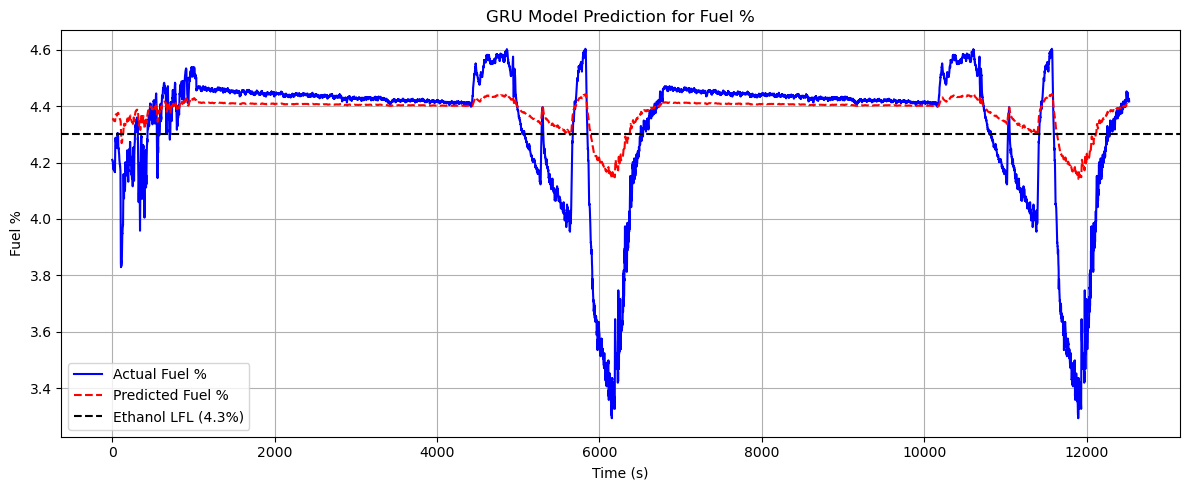

In [5]:
#Step 5: Make Predictions
model.eval()
y_pred = model(X_test).detach().numpy()
y_pred_rescaled = scaler.inverse_transform(y_pred)  #Convert back to original scale
y_test_rescaled = scaler.inverse_transform(y_test.numpy())  #Convert back

plt.figure(figsize=(12, 5))

#Plot actual and predicted values
plt.plot(y_test_rescaled, label="Actual Fuel %", color='blue')
plt.plot(y_pred_rescaled, label="Predicted Fuel %", color='red', linestyle="dashed")

#Add horizontal line at 4.3% Ethanol LFL
plt.axhline(y=4.3, color='black', linestyle='--', linewidth=1.5, label='Ethanol LFL (4.3%)')

#Labels and title
plt.xlabel("Time (s)")
plt.ylabel("Fuel %")
plt.title("GRU Model Prediction for Fuel %")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
#Print out warnings for when the values lie withing the upper and lower flammability limits
lower_bound = 4.3
upper_bound = 19 


for i, pred in enumerate(y_pred_rescaled):
    if lower_bound <= pred <= upper_bound:
        print(f"Warning: Prediction {pred[0]:.5f} at index {i} is within the specified range ({lower_bound} - {upper_bound}).")